In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.ensemble import AdaBoostClassifier as Ada
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt

/Users/sunny/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sunny/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#load data
df = pd.read_csv("all_ter_data.csv")

/Users/sunny/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (25,27,40,41,43,44,45,46,47,75,76,78,79,87,89,90,91,92,110) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
pd.set_option('max_colwidth',1200)
#remove the nulls, provider_id, reviewer_id
df = df[~pd.isnull(df.provider_id)]
#fill in zeros for the null in ht column
df['ht'].fillna(0,inplace = True)
df['ht'] = df['ht'].astype('bool')
v = df[['provider_id','general_details','juicy_details','ht']]
del df
#fill in the Na's in general and juicy details to be ''
v['general_details'].fillna("",inplace = True)
v['juicy_details'].fillna("",inplace = True)
#vectorizer using binary 
#stopWords = set(stopwords.words('english'))

In [8]:
#aggregate by reviewer_name
#v.provider_id.unique().size
vgroup = v.groupby('provider_id')
vlabel = vgroup['ht'].agg(['any'])
vdetail = vgroup['general_details'].apply(lambda x: ' '.join(x))
vjuicydetail = vgroup['juicy_details'].apply(lambda x: ' '.join(x))
vgroupinfo = pd.concat([vlabel,vdetail,vjuicydetail],1)
vgroupinfo['ht'] = vgroupinfo['any']
vgroupinfo['detail'] = vgroupinfo['general_details'] + vgroupinfo['juicy_details']
vgroupinfo = vgroupinfo.drop(['general_details', 'juicy_details','any'],axis = 1)

In [9]:
vgroupinfo

,ht,detail
provider_id,,
1.0,False,First she asked for more money. Then just danc...
3.0,False,Wendy is older than most people in the busines...
4.0,False,"Nice looking ""natural"" girl. She provided what..."
6.0,False,She is a very nice girl. The picture I don't t...
7.0,True,Madison provides a nice relaxing atmosphere wi...
8.0,False,I arrived in an average looking appartment wit...
9.0,False,She could have been more into what she was doi...
12.0,False,She was nice but she seemed like she was a lit...
13.0,True,"Had seen some mixed reviews, but my sense was ..."


In [12]:
# balanced data group,
def split_data_bala(df,poratio = 0.2,neratio = 0.01,neratio_train=0.03):
    '''
        @df: Dataframe of pre-processed data
        @poratio: test set ratio in whole positive samples, then (1-poratio) would be train ratio
        @neratio: test set ratio in whole negative samples
        @neratio_train: train set ratio in whole negatives samples. 
        we need to make sure the numbers of positive and negatives samples are close in both train and test dataset.
        @return: X_train, X_test, Y_train, Y_test
    '''
    poindex = np.array(df[df['ht'] == 1].index)
    neindex = np.array(df[df['ht'] == 0].index)
    np.random.shuffle(poindex)
    np.random.shuffle(neindex)
    npotest = int(np.ceil(len(poindex)*poratio))
    nnetest = int(np.ceil(len(neindex)*neratio))
    npotrain = int(np.ceil(len(poindex)*(1-poratio)))
    nnetrain = int(np.ceil(len(neindex)*(1-poratio)*neratio_train))
    X_test = pd.concat([df.loc[poindex[:npotest],'detail'],df.loc[neindex[:nnetest],'detail']])
    Y_test = pd.concat([df.loc[poindex[:npotest],'ht'],df.loc[neindex[:nnetest],'ht']])
    X_train = pd.concat([df.loc[poindex[npotest:npotest+npotrain],'detail'],df.loc[neindex[nnetest:nnetest+nnetrain],'detail']])
    Y_train = pd.concat([df.loc[poindex[npotest:npotest+npotrain],'ht'],df.loc[neindex[nnetest:nnetest+nnetrain],'ht']])
    return X_train, X_test, Y_train, Y_test

#unbalanced data
def split_data(df,ratio = 0.25):
    '''
        @ratio: test set ratio in whole dataset, the data would be unbalanced
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(df['detail'],df['ht'],test_size =ratio)
    return X_train, X_test, Y_train, Y_test

In [34]:
# choose balanced or unbalanced data
X_train, X_test, Y_train, Y_test = split_data_bala(vgroupinfo)

In [35]:
# show the numbers of positive and negative samples in train and test dataset
print(len(Y_train[Y_train == 1]))
print(len(Y_test[Y_test == 1]))
print(len(Y_train[Y_train == 0]))
print(len(Y_test[Y_test == 0]))

14803
3701
4773
1989


In [36]:
# Vectorize word by different methods: CountVectorizer would only consider the word frequency, while the TfidfVectorizer would also consider the frequency in documents
CV = CountVectorizer(ngram_range = (1,2),stop_words='english')
XCVtrain = CV.fit_transform(X_train.tolist())
XCVtest = CV.transform(X_test.tolist())
# TV = TfidfVectorizer(ngram_range = (1,2), stop_words='english')
# XCVtrain = TV.fit_transform(X_train.tolist())
# XCVtest = TV.transform(X_test.tolist())

In [38]:
# transfer data to DMatrix, the data structure used in xgboost
dtrain = xgb.DMatrix(XCVtrain, label=Y_train.tolist())
dtest = xgb.DMatrix(XCVtest, label=Y_test.tolist())

In [39]:
#choose parameters of xgboost.
param = {'max_depth': 5, 'eta': 0.01, 'objective': 'binary:logistic'}
param['eval_metric'] = ['auc', 'error']
plst = param.items()
num_round = 50

In [40]:
# train the model
bst = xgb.train(param, dtrain, num_round)
bst.eval(dtest)

'[0]\teval-auc:0.753387\teval-error:0.320211'

In [27]:
#unbalanced
bst = xgb.train(param, dtrain, num_round)
bst.eval(dtest)

'[0]\teval-auc:0.757409\teval-error:0.081858'

In [28]:
ypred = bst.predict(dtest)
ypred

array([0.33053464, 0.33053464, 0.31878155, ..., 0.3165986 , 0.3610102 ,
       0.32452244], dtype=float32)

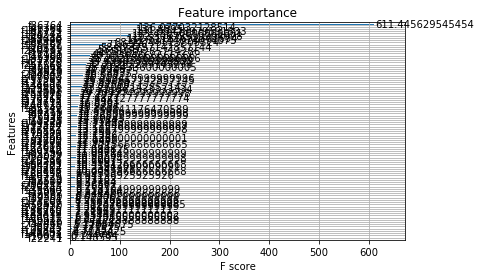

In [32]:
# show the feature importance by gain or weight
xgb.plot_importance(bst,importance_type='gain')
plt.show()

In [ ]:
# tune parameters, which costs much time. If you just want to train data and test performance, don't run this cell.
param_test1 = {
 'max_depth':[3,5,7,9],
 'n_estimators': [50,150,300]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=140, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8,  scale_pos_weight=1, seed=27), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3)

gsearch1.fit(XCVtrain,Y_train)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_